In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from scipy.stats import chi2_contingency

In [46]:
obs_df = pd.read_csv('observations.csv')
spcs_df = pd.read_csv('species_info.csv')

Inspecting the observations dataset.

In [47]:
obs_df.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


In [48]:
obs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23296 entries, 0 to 23295
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scientific_name  23296 non-null  object
 1   park_name        23296 non-null  object
 2   observations     23296 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 546.1+ KB


Inspecting the Species Information dataset.

In [49]:
spcs_df.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


In [50]:
spcs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             5824 non-null   object
 1   scientific_name      5824 non-null   object
 2   common_names         5824 non-null   object
 3   conservation_status  191 non-null    object
dtypes: object(4)
memory usage: 182.1+ KB


From the inspection, we have identified that there were missing values in the "conservation_status" column

In [51]:
spcs_df['conservation_status'].isna().sum()

5633

Replacing the missing values in 'conservation_status' as Low Risk. The categories are ordered.

In [52]:
spcs_df.conservation_status[spcs_df.conservation_status.isna()] = 'Low Risk'
spcs_df.conservation_status = pd.Categorical(spcs_df.conservation_status, 
                                               categories=['Low Risk', 'Species of Concern', 
                                                           'In Recovery', 'Threatened', 'Endangered'], 
                                               ordered=True)

Listing unique values in conservation_status

In [53]:
display(pd.DataFrame({'conservation_status':spcs_df.conservation_status.unique()}))

,conservation_status
0,Low Risk
1,Species of Concern
2,Endangered
3,Threatened
4,In Recovery


Finding out the number of duplicates in the scientific_name

In [54]:
s_duplicates = spcs_df[spcs_df['scientific_name'].duplicated(keep=False)]
print(f'Duplicates: {len(s_duplicates)}')
display(pd.DataFrame(s_duplicates))

Duplicates: 557


,category,scientific_name,common_names,conservation_status
4,Mammal,Cervus elaphus,Wapiti Or Elk,Low Risk
5,Mammal,Odocoileus virginianus,White-Tailed Deer,Low Risk
6,Mammal,Sus scrofa,"Feral Hog, Wild Pig",Low Risk
8,Mammal,Canis lupus,Gray Wolf,Endangered
10,Mammal,Urocyon cinereoargenteus,"Common Gray Fox, Gray Fox",Low Risk
...,...,...,...,...
5619,Vascular Plant,Panicum rigidulum var. rigidulum,"Redtop Panicgrass, Redtop Panicum",Low Risk
5638,Vascular Plant,Setaria pumila,"Cattail Grass, Yellow Bristle Grass, Yellow Br...",Low Risk
5640,Vascular Plant,Vulpia bromoides,"Brome Fescue, Brome Six-Weeks Grass, Desert Fe...",Low Risk
5643,Vascular Plant,Vulpia myuros,"Foxtail Fescue, Rattail Fescue, Rat-Tail Fescu...",Low Risk


On inspection, we find the duplicates of the same species have different conservation status.

In [55]:
cl_before= spcs_df[spcs_df['scientific_name']== 'Canis lupus']
cl_before = cl_before.style.set_caption('Canis Lupus duplicates before removal')
display(cl_before)

,category,scientific_name,common_names,conservation_status
8,Mammal,Canis lupus,Gray Wolf,Endangered
3020,Mammal,Canis lupus,"Gray Wolf, Wolf",In Recovery
4448,Mammal,Canis lupus,"Gray Wolf, Wolf",Endangered


Updating each species with the highest conservation status

In [56]:
#Removing all duplicates in the scientific_name column
spcs_df.drop_duplicates(inplace=True, subset='scientific_name', keep='first')

#The rows are grouped by each species with the highest level of conservation status
worst_cases = s_duplicates.groupby('scientific_name')['conservation_status'].max()

#updating each species with the highest level of conservation status
for species, worst_risk in worst_cases.iteritems():
    spcs_df['conservation_status'][spcs_df.scientific_name== species] = worst_risk
    
#Confirming that all duplicates are removed
cl_after = spcs_df[spcs_df.scientific_name.str.contains('Canis lupus')].reset_index(drop=True)
cl_after = cl_after.style.set_caption('Canis Lupus duplicates after removal')
display(cl_after)

,category,scientific_name,common_names,conservation_status
0,Mammal,Canis lupus,Gray Wolf,Endangered


Joining the updated dataframe (Species Information & Observation) into one dataframe

In [57]:
join_df = spcs_df.merge(obs_df, on='scientific_name', how='outer')
display(join_df.head(5).style.set_caption('Join process result (first 5 rows)'))

,category,scientific_name,common_names,conservation_status,park_name,observations
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,Low Risk,Bryce National Park,130
1,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,Low Risk,Yellowstone National Park,270
2,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,Low Risk,Great Smoky Mountains National Park,98
3,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,Low Risk,Yosemite National Park,117
4,Mammal,Bos bison,"American Bison, Bison",Low Risk,Yosemite National Park,128


The difference of the number of records seen in all dataframes

In [58]:
print(f'Length of s_info_df: \t{len(spcs_df)}')
print(f'Length of obs_df: \t{len(obs_df)}')
print(f'Length of join_df: \t{len(join_df)}')

Length of s_info_df: 	5541
Length of obs_df: 	23296
Length of join_df: 	23296


Listing Canis Lupus present in all parks

In [59]:
join_df[join_df['scientific_name']== 'Canis lupus']

,category,scientific_name,common_names,conservation_status,park_name,observations
44,Mammal,Canis lupus,Gray Wolf,Endangered,Yosemite National Park,35
45,Mammal,Canis lupus,Gray Wolf,Endangered,Bryce National Park,27
46,Mammal,Canis lupus,Gray Wolf,Endangered,Bryce National Park,29
47,Mammal,Canis lupus,Gray Wolf,Endangered,Bryce National Park,74
48,Mammal,Canis lupus,Gray Wolf,Endangered,Great Smoky Mountains National Park,15
49,Mammal,Canis lupus,Gray Wolf,Endangered,Yellowstone National Park,60
50,Mammal,Canis lupus,Gray Wolf,Endangered,Yellowstone National Park,67
51,Mammal,Canis lupus,Gray Wolf,Endangered,Yellowstone National Park,203
52,Mammal,Canis lupus,Gray Wolf,Endangered,Great Smoky Mountains National Park,14
53,Mammal,Canis lupus,Gray Wolf,Endangered,Yosemite National Park,117


Visualising the number of Organisms by Categories in a barplot

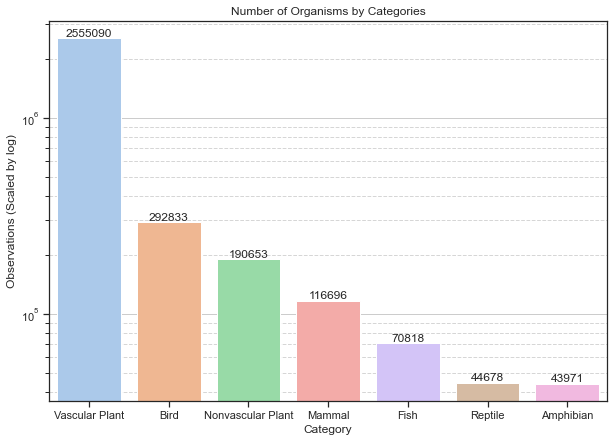

,category,observations
0,Vascular Plant,2555090
1,Bird,292833
2,Nonvascular Plant,190653
3,Mammal,116696
4,Fish,70818
5,Reptile,44678
6,Amphibian,43971


In [60]:
#Setting the aspects of the visual theme
sns.set_theme(style='ticks',palette="pastel", rc={'axes.grid': True})
#Grouping the variables by Category 
obs_and_cat_df = join_df[['category', 'observations']].groupby('category').sum().\
sort_values('observations', ascending=False).reset_index()
#plotting the variables in barplot
plt.figure(figsize=[10, 7])
sns.barplot(x=obs_and_cat_df.category, y=obs_and_cat_df.observations)

plt.xlabel('Category')
plt.ylabel('Observations (Scaled by log)')

x=obs_and_cat_df.category
y=obs_and_cat_df.observations

#sclaing the bar by log
plt.yscale('log')
#adding labels to bars
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i], horizontalalignment='center', verticalalignment='bottom')

addlabels(x, y)
plt.grid(b=True, which='minor', linestyle='--', alpha=0.8)
plt.title('Number of Organisms by Categories')

plt.show()

display(obs_and_cat_df)

Visualising the number of organisms by categories and park in a barplot

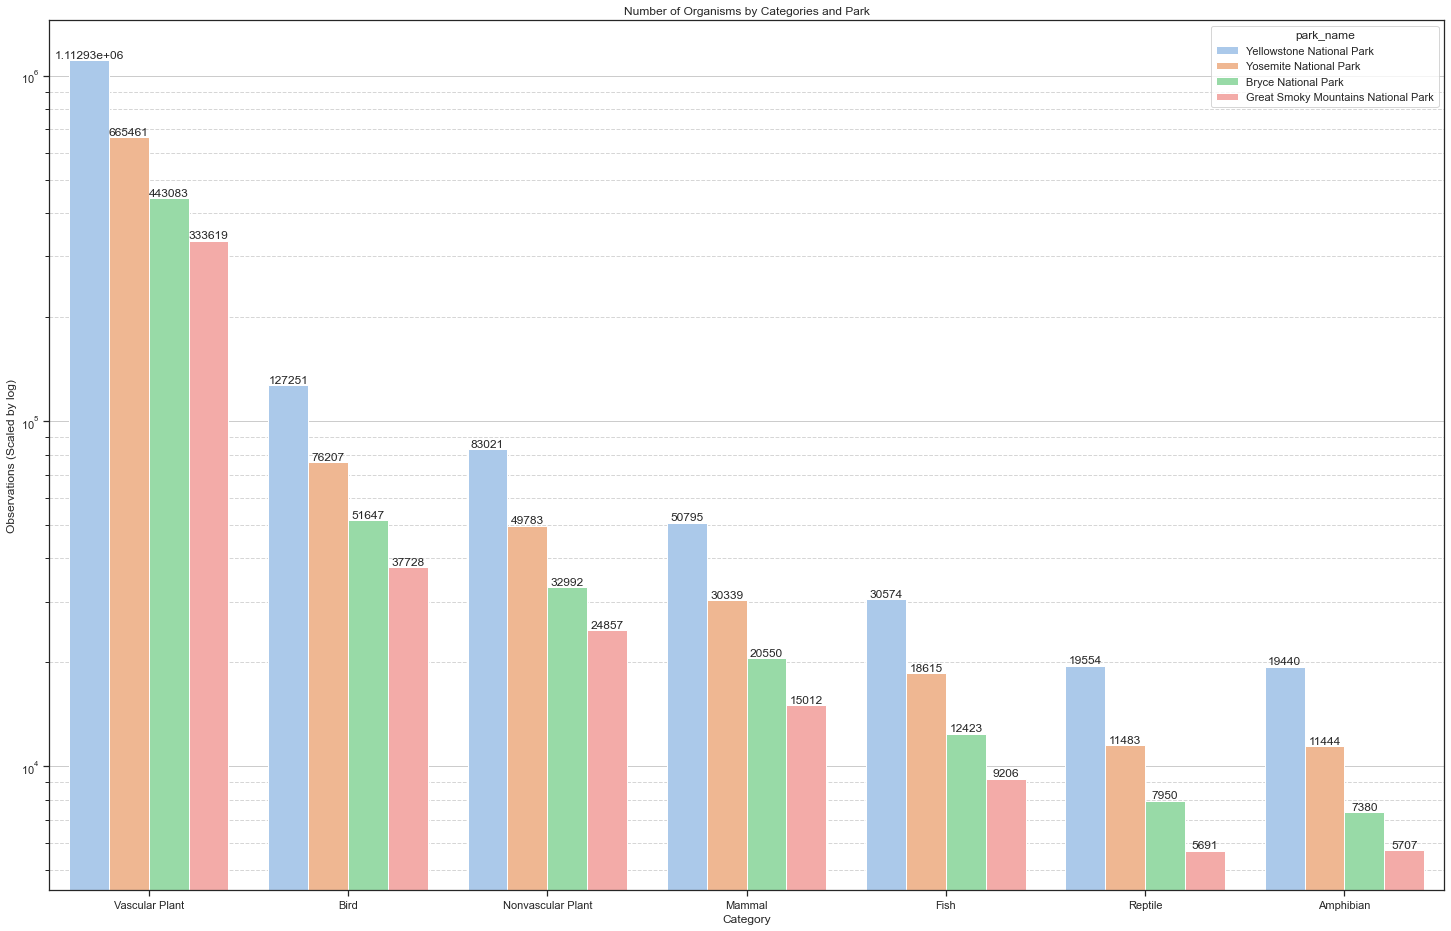

,category,park_name,observations
0,Vascular Plant,Yellowstone National Park,1112927
1,Vascular Plant,Yosemite National Park,665461
2,Vascular Plant,Bryce National Park,443083
3,Vascular Plant,Great Smoky Mountains National Park,333619
4,Bird,Yellowstone National Park,127251
5,Nonvascular Plant,Yellowstone National Park,83021
6,Bird,Yosemite National Park,76207
7,Bird,Bryce National Park,51647
8,Mammal,Yellowstone National Park,50795
9,Nonvascular Plant,Yosemite National Park,49783


In [61]:
#Setting the aspects of the visual theme
sns.set_theme(style='ticks',palette="pastel", rc={'axes.grid': True})

#Grouping the variables by Category then by the Name of park
obs_and_cat_df2 = join_df[['category', 'observations', 'park_name']].groupby(['category', 'park_name'])\
                    .sum().sort_values('observations', ascending=False).reset_index()

#plotting the variables in barplot
plt.figure(figsize=[25, 16])
ax= sns.barplot(x=obs_and_cat_df2.category, y=obs_and_cat_df2.observations, hue=obs_and_cat_df2.park_name)

plt.xlabel('Category')
plt.ylabel('Observations (Scaled by log)')

#sclaing the bar by log
plt.yscale('log')
#adding labels to bars
for container in ax.containers:
    ax.bar_label(container)

plt.grid(b=True, which='minor', linestyle='--', alpha=0.8)
plt.title('Number of Organisms by Categories and Park')

plt.show()

display(obs_and_cat_df2)

In [62]:
join_df

,category,scientific_name,common_names,conservation_status,park_name,observations
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,Low Risk,Bryce National Park,130
1,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,Low Risk,Yellowstone National Park,270
2,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,Low Risk,Great Smoky Mountains National Park,98
3,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,Low Risk,Yosemite National Park,117
4,Mammal,Bos bison,"American Bison, Bison",Low Risk,Yosemite National Park,128
...,...,...,...,...,...,...
23291,Vascular Plant,Vitis californica,"California Grape, California Wild Grape",Low Risk,Yellowstone National Park,237
23292,Vascular Plant,Tribulus terrestris,"Bullhead, Caltrop, Goathead, Mexican Sandbur, ...",Low Risk,Great Smoky Mountains National Park,50
23293,Vascular Plant,Tribulus terrestris,"Bullhead, Caltrop, Goathead, Mexican Sandbur, ...",Low Risk,Yellowstone National Park,239
23294,Vascular Plant,Tribulus terrestris,"Bullhead, Caltrop, Goathead, Mexican Sandbur, ...",Low Risk,Bryce National Park,111


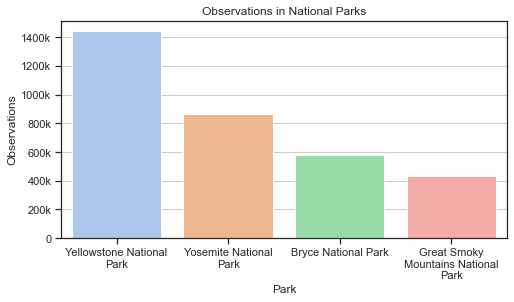

In [63]:
# Bar plot absolute values of observations
plt.figure(figsize=[8, 4])
ax= sns.barplot(data=join_df, x='park_name', y='observations', estimator=sum,\
                ci=None, order=join_df.groupby('park_name')['observations'].\
                agg('sum').sort_values(ascending=False).index)
#Format column labels
import textwrap
max_width = 20
ax.set_xticklabels(textwrap.fill(x.get_text(), max_width) for x in ax.get_xticklabels())
# Labels
plt.xlabel('Park')
plt.xticks(rotation=0)
plt.ylabel('Observations')
# y axis as thousands of observations
plt.grid(b=True, which='minor', linestyle='--', alpha=0.8)
plt.gca().yaxis.set_major_formatter(lambda x, pos: '0' if x==0 else '{:.0f}k'.format(x * 1e-3))

# Title
plt.title('Observations in National Parks')

plt.show()

In [64]:
#Creating a pivot table with Park Name as index and Values of Category in the column
obs_and_park_df = join_df.pivot_table(index='category', columns='park_name', values='observations'\
                                      , aggfunc=sum)
#Convert Observation values into percentage based on its category
obs_and_park_df= obs_and_park_df.apply(lambda x: x/x.sum()*100, axis=1)


#Rename row/column description
obs_and_park_df.rename_axis('Category', inplace=True)
obs_and_park_df.rename_axis('Park Name', axis='columns', inplace=True)


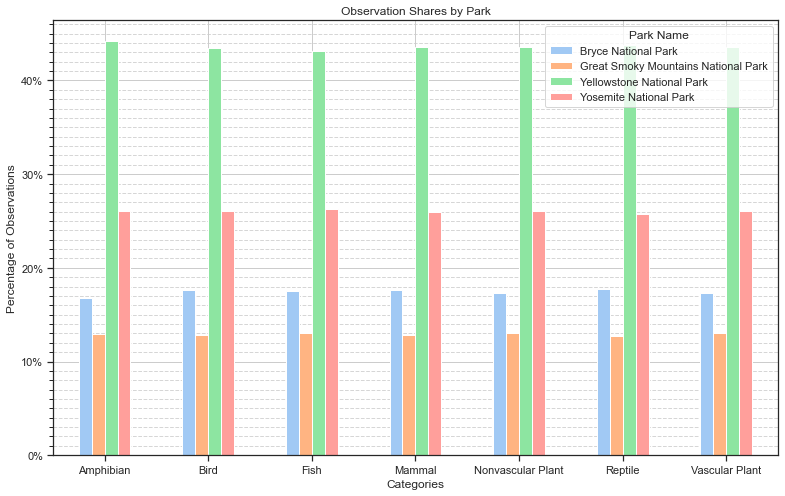

Park Name,Bryce National Park,Great Smoky Mountains National Park,Yellowstone National Park,Yosemite National Park
Category,,,,
Amphibian,16.8%,13.0%,44.2%,26.0%
Bird,17.6%,12.9%,43.5%,26.0%
Fish,17.5%,13.0%,43.2%,26.3%
Mammal,17.6%,12.9%,43.5%,26.0%
Nonvascular Plant,17.3%,13.0%,43.5%,26.1%
Reptile,17.8%,12.7%,43.8%,25.7%
Vascular Plant,17.3%,13.1%,43.6%,26.0%


In [65]:
ax= obs_and_park_df.plot(kind='bar', stacked=False, figsize=[13, 8])
# Labels
plt.xlabel('Categories')
plt.ylabel('Percentage of Observations')
# y axis as thousands of observations
plt.grid(b=True, which='minor', linestyle='--', alpha=0.8)
plt.gca().yaxis.set_minor_locator(MultipleLocator(1))
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}%'.format(x))

plt.xticks(rotation=0)
# Title
plt.title('Observation Shares by Park')

plt.show()

# Add table
display(obs_and_park_df.style
        .format("{:.1f}%")
        .set_caption('Observation percentages'))


In [66]:
spcs_df[spcs_df.common_names.str.contains("myotis", case=False)]

,category,scientific_name,common_names,conservation_status
33,Mammal,Myotis austroriparius,"Mississippi Myotis, Southeastern Myotis",Species of Concern
34,Mammal,Myotis grisescens,Gray Myotis,Endangered
35,Mammal,Myotis keenii,Keen's Myotis,Species of Concern
36,Mammal,Myotis leibii,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern
37,Mammal,Myotis lucifugus,"Little Brown Bat, Little Brown Myotis",Species of Concern
38,Mammal,Myotis septentrionalis,"Northern Long-Eared Bat, Northern Myotis",Threatened
39,Mammal,Myotis sodalis,"Indiana Bat, Indiana Or Social Myotis",Endangered
3039,Mammal,Myotis californicus,"California Myotis, California Myotis, Californ...",Species of Concern
3040,Mammal,Myotis ciliolabrum,"Small-Footed Myotis, Western Small-Footed Bat,...",Low Risk
3041,Mammal,Myotis evotis,"Long-Eared Myotis, Long-Eared Myotis",Species of Concern


In [67]:

# Remove low risk from categories
endangered_spcs = spcs_df[spcs_df.conservation_status != 'Low Risk']
endangered_obs = join_df[join_df.conservation_status != 'Low Risk']

endangered_spcs.conservation_status = endangered_spcs.conservation_status.cat.remove_unused_categories()
endangered_obs.conservation_status = endangered_obs.conservation_status.cat.remove_unused_categories()

bag_words = endangered_obs.common_names.str.replace(',', '').str.split('\s')
# Create a list of words
names_words = []
for index, words in bag_words.iteritems():
    names_words.extend(words)
# Find values count
names_words = pd.Series(names_words, name='word_count')
word_count = names_words.value_counts().to_frame()
# Look at first 20
display(word_count[:20].style.set_caption('Frequent words - top 20'))


C:\Python\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,word_count
Myotis,96
Bat,60
Brown,40
Northern,28
California,28
American,28
Mountain,28
Little,24
Warbler,16
Hawk,16


Visualising the number of endangered species seperately by categories

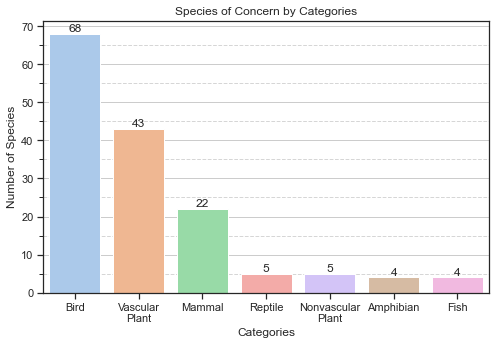

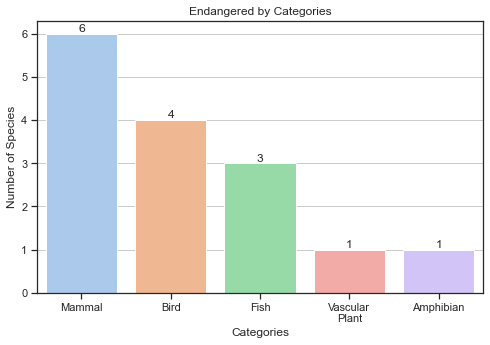

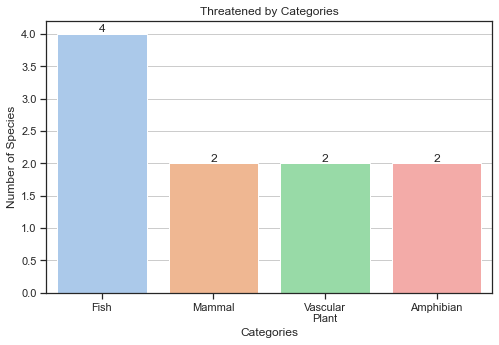

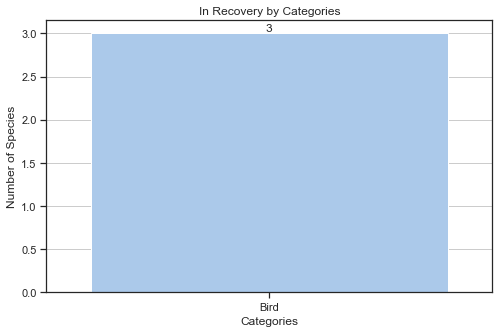

In [68]:
#Converting the all unique values in 'conservation_status' as list
lists= endangered_spcs['conservation_status'].unique().to_list()
for list in lists:
    spcs_of_concern = endangered_spcs.drop(endangered_spcs\
                                    [endangered_spcs['conservation_status']\
                                     !=list].index).reset_index(drop=True)
    # Countplot
    plt.figure(figsize=[8, 5])
    ax= sns.countplot(data=spcs_of_concern, x= 'category', order=spcs_of_concern['category'].value_counts(ascending=False).index);   
    abs_values = spcs_of_concern['category'].value_counts(ascending=False).values
    ax.bar_label(container=ax.containers[0], labels=abs_values)

    # Labels
    plt.xlabel('Categories')
    plt.ylabel('Number of Species')
    # y axis as thousands of observations
    plt.grid(b=True, which='minor', linestyle='--', alpha=0.8)
    plt.gca().yaxis.set_minor_locator(MultipleLocator(5))
    plt.title(list + ' by Categories')

    max_width = 11
    ax.set_xticklabels(textwrap.fill(x.get_text(), max_width) for x in ax.get_xticklabels())

    plt.show()

Visualising the number of endangered species by categories

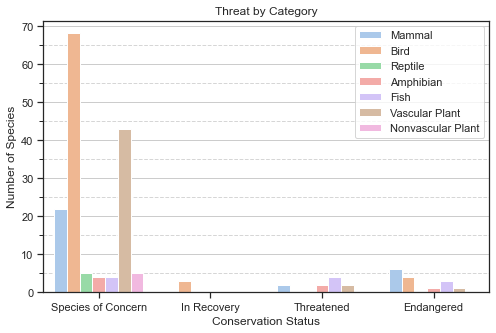

In [69]:
# Countplot
plt.figure(figsize=[8, 5])
sns.countplot(data=endangered_spcs, 
              x="conservation_status", hue="category")
# Labels
plt.xlabel('Conservation Status')
plt.ylabel('Number of Species')
# y axis as thousands of observations
plt.grid(b=True, which='minor', linestyle='--', alpha=0.8)
plt.gca().yaxis.set_minor_locator(MultipleLocator(5))
# Title
plt.title('Threat by Category')
# Legend
plt.legend(loc='upper right')

plt.show()

In [70]:
SP_and_HW = join_df[(join_df.common_names.str.contains('Hawk|Sparrow')) 
                    & (join_df.category == 'Bird')].copy()
SP_and_HW = SP_and_HW[['park_name', 'common_names', 'conservation_status']].reset_index(drop=True)
SP_and_HW['hawk_or_sparrow'] = SP_and_HW.common_names.apply(lambda x: 'Hawk' if 'Hawk' in x else 'Sparrow')
display(pd.concat([SP_and_HW.head(), SP_and_HW.tail()]).style
                  .set_caption('Sparrows and hawks observations (first and last rows)'))

contingency_SP_HW = pd.crosstab(SP_and_HW.conservation_status, SP_and_HW.hawk_or_sparrow)
contingency_SP_HW.rename_axis('Conservation Status', inplace=True)
contingency_SP_HW.rename_axis('Hawk/Sparrow', axis='columns', inplace=True)
display(contingency_SP_HW.style.set_caption('Contingency table'))


,park_name,common_names,conservation_status,hawk_or_sparrow
0,Bryce National Park,Cooper's Hawk,Species of Concern,Hawk
1,Yosemite National Park,Cooper's Hawk,Species of Concern,Hawk
2,Yellowstone National Park,Cooper's Hawk,Species of Concern,Hawk
3,Great Smoky Mountains National Park,Cooper's Hawk,Species of Concern,Hawk
4,Yosemite National Park,Sharp-Shinned Hawk,Species of Concern,Hawk
143,Yosemite National Park,Gambel's White-Crowned Sparrow,Low Risk,Sparrow
144,Great Smoky Mountains National Park,Mountain White-Crowned Sparrow,Low Risk,Sparrow
145,Yellowstone National Park,Mountain White-Crowned Sparrow,Low Risk,Sparrow
146,Bryce National Park,Mountain White-Crowned Sparrow,Low Risk,Sparrow
147,Yosemite National Park,Mountain White-Crowned Sparrow,Low Risk,Sparrow


Hawk/Sparrow,Hawk,Sparrow
Conservation Status,,
Low Risk,16,100
Species of Concern,16,16


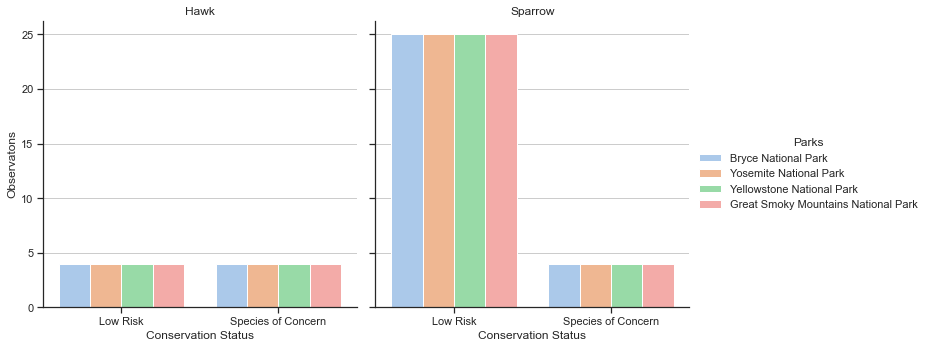

In [71]:
SP_and_HW.conservation_status = SP_and_HW.conservation_status.cat.remove_unused_categories()

# Countplot
g = sns.catplot(x='conservation_status', col='hawk_or_sparrow',
                hue='park_name', data=SP_and_HW,
                kind="count", height=5,
                legend=True)

# Improve lables
for ax in g.axes[0,:]:
    ax.set_xlabel('Conservation Status')
g.axes[0,0].set_ylabel('Observatons')
g.axes[0,0].set_title('Hawk')
g.axes[0,1].set_title('Sparrow')
g._legend.set_title('Parks')
plt.show()

In [72]:
join_df.to_csv('join_diversity.csv', index=False)